In [18]:
import numpy as np
import pandas as pd
import os, datetime
import tensorflow as tf
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
print('Tensorflow version: {}'.format(tf.__version__))

import matplotlib.pyplot as plt
plt.style.use('seaborn')

import warnings
warnings.filterwarnings('ignore')

Tensorflow version: 2.4.0


## Hyperparameters

In [19]:
batch_size = 32
seq_len = 128

d_k = 256
d_v = 256
n_heads = 12
ff_dim = 256


## Load EURUSD data

In [20]:
IBM_path = '/Users/tizianfischer/Desktop/EURUSD4.csv'

df = pd.read_csv(IBM_path, delimiter=';', usecols=['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'Value', 'Number Ticks'])

# Replace 0 to avoid dividing by 0 later on
df['Volume'].replace(to_replace=0, method='ffill', inplace=True) 
df.sort_values('Date', inplace=True)
df.tail()

,Date,Open,High,Low,Close,Volume,Value,Number Ticks
1733,15.12.20 04:48,1.21506,1.21507,1.21501,1.21501,149000000,181039568,27
1736,15.12.20 04:49,1.21507,1.21508,1.21500,1.21500,158000000,191975120,28
1734,15.12.20 04:49,1.21503,1.21508,1.21501,1.21507,147049999,178673616,24
1735,15.12.20 04:49,1.21507,1.21509,1.21506,1.21508,160049999,194471968,27
1737,15.12.20 04:49,1.21500,1.21502,1.21497,1.21499,167000000,202904768,29


## Plot daily EURUSD closing prices and volume

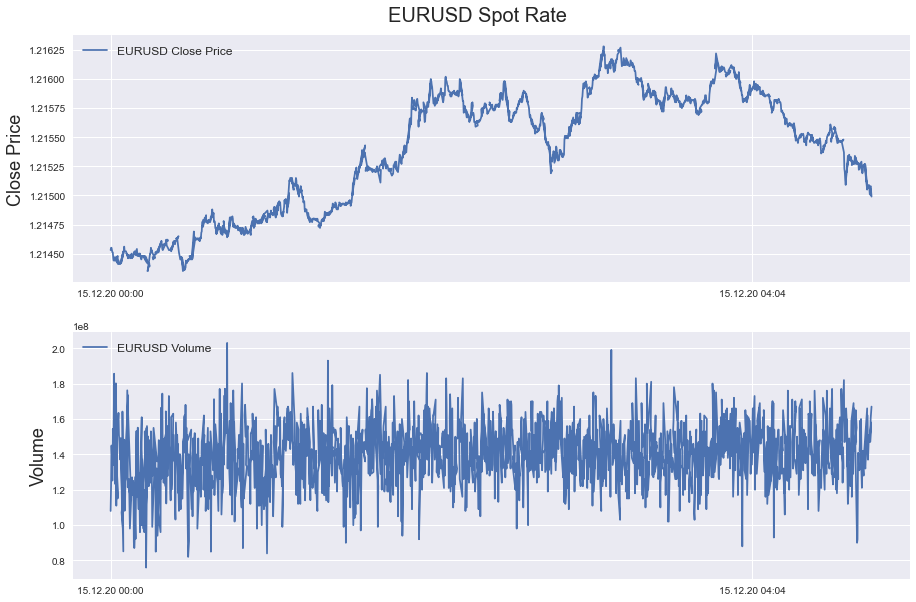

In [21]:
fig = plt.figure(figsize=(15,10))
st = fig.suptitle("EURUSD Spot Rate", fontsize=20)
st.set_y(0.92)

ax1 = fig.add_subplot(211)
ax1.plot(df['Close'], label='EURUSD Close Price')
ax1.set_xticks(range(0, df.shape[0], 1464))
ax1.set_xticklabels(df['Date'].loc[::1464])
ax1.set_ylabel('Close Price', fontsize=18)
ax1.legend(loc="upper left", fontsize=12)

ax2 = fig.add_subplot(212)
ax2.plot(df['Volume'], label='EURUSD Volume')
ax2.set_xticks(range(0, df.shape[0], 1464))
ax2.set_xticklabels(df['Date'].loc[::1464])
ax2.set_ylabel('Volume', fontsize=18)
ax2.legend(loc="upper left", fontsize=12)

## Calculate normalized percentage change of all columns

In [22]:
'''Calculate percentage change'''

df['Open'] = df['Open'].pct_change() # Create arithmetic returns column
df['High'] = df['High'].pct_change() # Create arithmetic returns column
df['Low'] = df['Low'].pct_change() # Create arithmetic returns column
df['Close'] = df['Close'].pct_change() # Create arithmetic returns column
df['Volume'] = df['Volume'].pct_change()
df['Value'] = df['Value'].pct_change()
df['Number Ticks'] = df['Number Ticks'].pct_change()

df.dropna(how='any', axis=0, inplace=True) # Drop all rows with NaN values

###############################################################################
'''Normalize price columns'''

min_return = min(df[['Open', 'High', 'Low', 'Close']].min(axis=0))
max_return = max(df[['Open', 'High', 'Low', 'Close']].max(axis=0))

# Min-max normalize price columns (0-1 range)
df['Open'] = (df['Open'] - min_return) / (max_return - min_return)
df['High'] = (df['High'] - min_return) / (max_return - min_return)
df['Low'] = (df['Low'] - min_return) / (max_return - min_return)
df['Close'] = (df['Close'] - min_return) / (max_return - min_return)

###############################################################################
'''Normalize volume column'''

min_volume = df['Volume'].min(axis=0)
max_volume = df['Volume'].max(axis=0)

# Min-max normalize volume columns (0-1 range)
df['Volume'] = (df['Volume'] - min_volume) / (max_volume - min_volume)

###############################################################################
'''Normalize value column'''

min_value = df['Value'].min(axis=0)
max_value = df['Value'].max(axis=0)

# Min-max normalize volume columns (0-1 range)
df['Value'] = (df['Value'] - min_value) / (max_value - min_value)

###############################################################################
'''Normalize Number Ticks column'''

min_numberticks = df['Number Ticks'].min(axis=0)
max_numberticks = df['Number Ticks'].max(axis=0)

# Min-max normalize volume columns (0-1 range)
df['Number Ticks'] = (df['Number Ticks'] - min_numberticks) / (max_numberticks - min_numberticks)

###############################################################################
'''Create training, validation and test split'''

times = sorted(df.index.values)
last_10pct = sorted(df.index.values)[-int(0.1*len(times))] # Last 10% of series
last_20pct = sorted(df.index.values)[-int(0.2*len(times))] # Last 20% of series

df_train = df[(df.index < last_20pct)]  # Training data are 80% of total data
df_val = df[(df.index >= last_20pct) & (df.index < last_10pct)]
df_test = df[(df.index >= last_10pct)]

# Remove date column
df_train.drop(columns=['Date'], inplace=True)
df_val.drop(columns=['Date'], inplace=True)
df_test.drop(columns=['Date'], inplace=True)

# Convert pandas columns into arrays
train_data = df_train.values
val_data = df_val.values
test_data = df_test.values
print('Training data shape: {}'.format(train_data.shape))
print('Validation data shape: {}'.format(val_data.shape))
print('Test data shape: {}'.format(test_data.shape))

df_train.head()

Training data shape: (1390, 7)
Validation data shape: (174, 7)
Test data shape: (173, 7)


,Open,High,Low,Close,Volume,Value,Number Ticks
1,0.499764,0.706811,0.517017,0.551525,0.413871,0.413875,0.425320
2,0.551526,0.396251,0.517017,0.517017,0.451812,0.451805,0.485199
3,0.499764,0.551524,0.534272,0.482510,0.303706,0.303710,0.351351
4,0.517017,0.413499,0.448000,0.482510,0.266406,0.266376,0.238919
5,0.465256,0.499764,0.568782,0.517017,0.480867,0.480874,0.418275


## Plot daily changes of close prices and volume

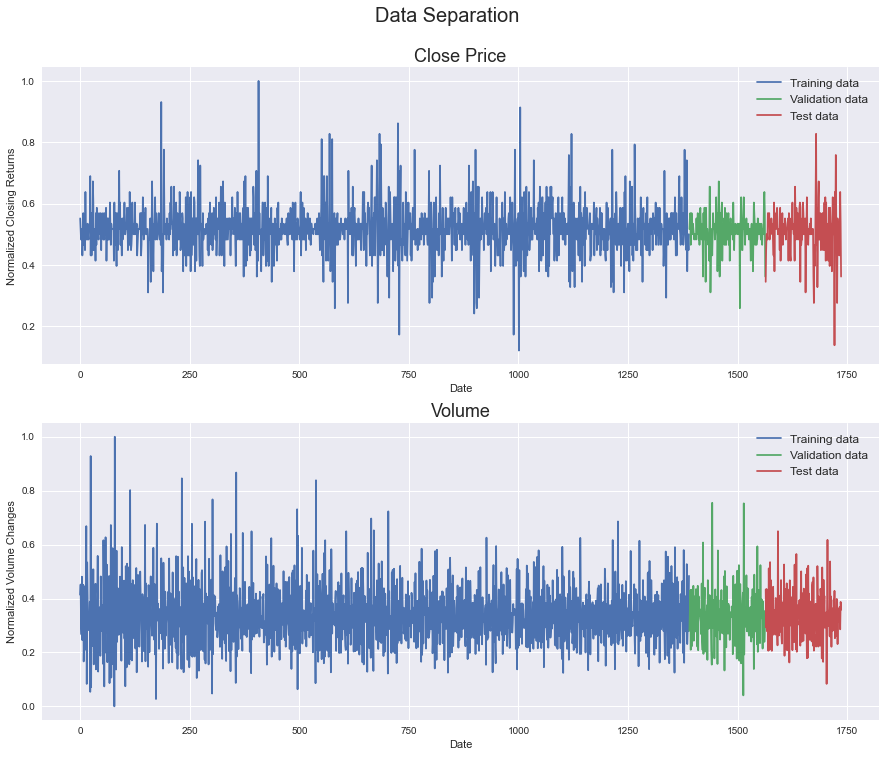

In [23]:
fig = plt.figure(figsize=(15,12))
st = fig.suptitle("Data Separation", fontsize=20)
st.set_y(0.95)

###############################################################################

ax1 = fig.add_subplot(211)
ax1.plot(np.arange(train_data.shape[0]), df_train['Close'], label='Training data')

ax1.plot(np.arange(train_data.shape[0], 
                   train_data.shape[0]+val_data.shape[0]), df_val['Close'], label='Validation data')

ax1.plot(np.arange(train_data.shape[0]+val_data.shape[0], 
                   train_data.shape[0]+val_data.shape[0]+test_data.shape[0]), df_test['Close'], label='Test data')
ax1.set_xlabel('Date')
ax1.set_ylabel('Normalized Closing Returns')
ax1.set_title("Close Price", fontsize=18)
ax1.legend(loc="best", fontsize=12)

###############################################################################

ax2 = fig.add_subplot(212)
ax2.plot(np.arange(train_data.shape[0]), df_train['Volume'], label='Training data')

ax2.plot(np.arange(train_data.shape[0], 
                   train_data.shape[0]+val_data.shape[0]), df_val['Volume'], label='Validation data')

ax2.plot(np.arange(train_data.shape[0]+val_data.shape[0], 
                   train_data.shape[0]+val_data.shape[0]+test_data.shape[0]), df_test['Volume'], label='Test data')
ax2.set_xlabel('Date')
ax2.set_ylabel('Normalized Volume Changes')
ax2.set_title("Volume", fontsize=18)
ax2.legend(loc="best", fontsize=12)

## Create chunks of training, validation and test data

In [24]:
# Training data
X_train, y_train = [], []
for i in range(seq_len, len(train_data)):
  X_train.append(train_data[i-seq_len:i]) # Chunks of training data with a length of 128 df-rows
  y_train.append(train_data[:, 3][i]) #Value of 4th column (Close Price) of df-row 128+1
X_train, y_train = np.array(X_train), np.array(y_train)

###############################################################################

# Validation data
X_val, y_val = [], []
for i in range(seq_len, len(val_data)):
    X_val.append(val_data[i-seq_len:i])
    y_val.append(val_data[:, 3][i])
X_val, y_val = np.array(X_val), np.array(y_val)

###############################################################################

# Test data
X_test, y_test = [], []
for i in range(seq_len, len(test_data)):
    X_test.append(test_data[i-seq_len:i])
    y_test.append(test_data[:, 3][i])    
X_test, y_test = np.array(X_test), np.array(y_test)

print('Training set shape', X_train.shape, y_train.shape)
print('Validation set shape', X_val.shape, y_val.shape)
print('Testing set shape' ,X_test.shape, y_test.shape)

Training set shape (1262, 128, 7) (1262,)
Validation set shape (46, 128, 7) (46,)
Testing set shape (45, 128, 7) (45,)


## TimeVector

In [25]:
class Time2Vector(Layer):
  def __init__(self, seq_len, **kwargs):
    super(Time2Vector, self).__init__()
    self.seq_len = seq_len

  def build(self, input_shape):
    '''Initialize weights and biases with shape (batch, seq_len)'''
    self.weights_linear = self.add_weight(name='weight_linear',
                                shape=(int(self.seq_len),),
                                initializer='uniform',
                                trainable=True)
    
    self.bias_linear = self.add_weight(name='bias_linear',
                                shape=(int(self.seq_len),),
                                initializer='uniform',
                                trainable=True)
    
    self.weights_periodic = self.add_weight(name='weight_periodic',
                                shape=(int(self.seq_len),),
                                initializer='uniform',
                                trainable=True)

    self.bias_periodic = self.add_weight(name='bias_periodic',
                                shape=(int(self.seq_len),),
                                initializer='uniform',
                                trainable=True)

  def call(self, x):
    '''Calculate linear and periodic time features'''
    x = tf.math.reduce_mean(x[:,:,:4], axis=-1) 
    time_linear = self.weights_linear * x + self.bias_linear # Linear time feature
    time_linear = tf.expand_dims(time_linear, axis=-1) # Add dimension (batch, seq_len, 1)
    
    time_periodic = tf.math.sin(tf.multiply(x, self.weights_periodic) + self.bias_periodic)
    time_periodic = tf.expand_dims(time_periodic, axis=-1) # Add dimension (batch, seq_len, 1)
    return tf.concat([time_linear, time_periodic], axis=-1) # shape = (batch, seq_len, 2)
   
  def get_config(self): # Needed for saving and loading model with custom layer
    config = super().get_config().copy()
    config.update({'seq_len': self.seq_len})
    return config
  

## Transformer

In [26]:
class SingleAttention(Layer):
  def __init__(self, d_k, d_v):
    super(SingleAttention, self).__init__()
    self.d_k = d_k
    self.d_v = d_v

  def build(self, input_shape):
    self.query = Dense(self.d_k, 
                       input_shape=input_shape, 
                       kernel_initializer='glorot_uniform', 
                       bias_initializer='glorot_uniform')
    
    self.key = Dense(self.d_k, 
                     input_shape=input_shape, 
                     kernel_initializer='glorot_uniform', 
                     bias_initializer='glorot_uniform')
    
    self.value = Dense(self.d_v, 
                       input_shape=input_shape, 
                       kernel_initializer='glorot_uniform', 
                       bias_initializer='glorot_uniform')

  def call(self, inputs): # inputs = (in_seq, in_seq, in_seq)
    q = self.query(inputs[0])
    k = self.key(inputs[1])

    attn_weights = tf.matmul(q, k, transpose_b=True)
    attn_weights = tf.map_fn(lambda x: x/np.sqrt(self.d_k), attn_weights)
    attn_weights = tf.nn.softmax(attn_weights, axis=-1)
    
    v = self.value(inputs[2])
    attn_out = tf.matmul(attn_weights, v)
    return attn_out    

#############################################################################

class MultiAttention(Layer):
  def __init__(self, d_k, d_v, n_heads):
    super(MultiAttention, self).__init__()
    self.d_k = d_k
    self.d_v = d_v
    self.n_heads = n_heads
    self.attn_heads = list()

  def build(self, input_shape):
    for n in range(self.n_heads):
      self.attn_heads.append(SingleAttention(self.d_k, self.d_v))  
    
    # input_shape[0]=(batch, seq_len, 7), input_shape[0][-1]=7 
    self.linear = Dense(input_shape[0][-1], 
                        input_shape=input_shape, 
                        kernel_initializer='glorot_uniform', 
                        bias_initializer='glorot_uniform')

  def call(self, inputs):
    attn = [self.attn_heads[i](inputs) for i in range(self.n_heads)]
    concat_attn = tf.concat(attn, axis=-1)
    multi_linear = self.linear(concat_attn)
    return multi_linear   

#############################################################################

class TransformerEncoder(Layer):
  def __init__(self, d_k, d_v, n_heads, ff_dim, dropout=0.1, **kwargs):
    super(TransformerEncoder, self).__init__()
    self.d_k = d_k
    self.d_v = d_v
    self.n_heads = n_heads
    self.ff_dim = ff_dim
    self.attn_heads = list()
    self.dropout_rate = dropout

  def build(self, input_shape):
    self.attn_multi = MultiAttention(self.d_k, self.d_v, self.n_heads)
    self.attn_dropout = Dropout(self.dropout_rate)
    self.attn_normalize = LayerNormalization(input_shape=input_shape, epsilon=1e-6)

    self.ff_conv1D_1 = Conv1D(filters=self.ff_dim, kernel_size=1, activation='relu')
    # input_shape[0]=(batch, seq_len, 7), input_shape[0][-1] = 7 
    self.ff_conv1D_2 = Conv1D(filters=input_shape[0][-1], kernel_size=1) 
    self.ff_dropout = Dropout(self.dropout_rate)
    self.ff_normalize = LayerNormalization(input_shape=input_shape, epsilon=1e-6)    
  
  def call(self, inputs): # inputs = (in_seq, in_seq, in_seq)
    attn_layer = self.attn_multi(inputs)
    attn_layer = self.attn_dropout(attn_layer)
    attn_layer = self.attn_normalize(inputs[0] + attn_layer)

    ff_layer = self.ff_conv1D_1(attn_layer)
    ff_layer = self.ff_conv1D_2(ff_layer)
    ff_layer = self.ff_dropout(ff_layer)
    ff_layer = self.ff_normalize(inputs[0] + ff_layer)
    return ff_layer 

  def get_config(self): # Needed for saving and loading model with custom layer
    config = super().get_config().copy()
    config.update({'d_k': self.d_k,
                   'd_v': self.d_v,
                   'n_heads': self.n_heads,
                   'ff_dim': self.ff_dim,
                   'attn_heads': self.attn_heads,
                   'dropout_rate': self.dropout_rate})
    return config          

## Model

In [27]:
def create_model():
  '''Initialize time and transformer layers'''
  time_embedding = Time2Vector(seq_len)
  attn_layer1 = TransformerEncoder(d_k, d_v, n_heads, ff_dim)
  attn_layer2 = TransformerEncoder(d_k, d_v, n_heads, ff_dim)
  attn_layer3 = TransformerEncoder(d_k, d_v, n_heads, ff_dim)

  '''Construct model'''
  in_seq = Input(shape=(seq_len, 7))
  x = time_embedding(in_seq)
  x = Concatenate(axis=-1)([in_seq, x])
  x = attn_layer1((x, x, x))
  x = attn_layer2((x, x, x))
  x = attn_layer3((x, x, x))
  x = GlobalAveragePooling1D(data_format='channels_first')(x)
  x = Dropout(0.1)(x)
  x = Dense(64, activation='relu')(x)
  x = Dropout(0.1)(x)
  out = Dense(1, activation='linear')(x)

  model = Model(inputs=in_seq, outputs=out)
  model.compile(loss='mse', optimizer='adam', metrics=['mae', 'mape'])
  return model


model = create_model()
model.summary()

callback = tf.keras.callbacks.ModelCheckpoint('content/Transformer+TimeEmbedding.hdf5', 
                                              monitor='val_loss', 
                                              save_best_only=True, verbose=1)
if True: 
    history = model.fit(X_train, y_train, 
                        batch_size=batch_size, 
                        epochs=5, 
                        callbacks=[callback],
                        validation_data=(X_val, y_val))  
# else    
#    model.save(.h5)
#    model.load

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 128, 7)]     0                                            
__________________________________________________________________________________________________
time2_vector_2 (Time2Vector)    (None, 128, 2)       512         input_3[0][0]                    
__________________________________________________________________________________________________
concatenate_2 (Concatenate)     (None, 128, 9)       0           input_3[0][0]                    
                                                                 time2_vector_2[0][0]             
__________________________________________________________________________________________________
transformer_encoder_6 (Transfor (None, 128, 9)       124726      concatenate_2[0][0]        

 
Evaluation metrics
Training Data - Loss: 0.0066, MAE: 0.0555, MAPE: 11.4001
Validation Data - Loss: 0.0024, MAE: 0.0348, MAPE: 7.1335
Test Data - Loss: 0.0104, MAE: 0.0718, MAPE: 19.4284


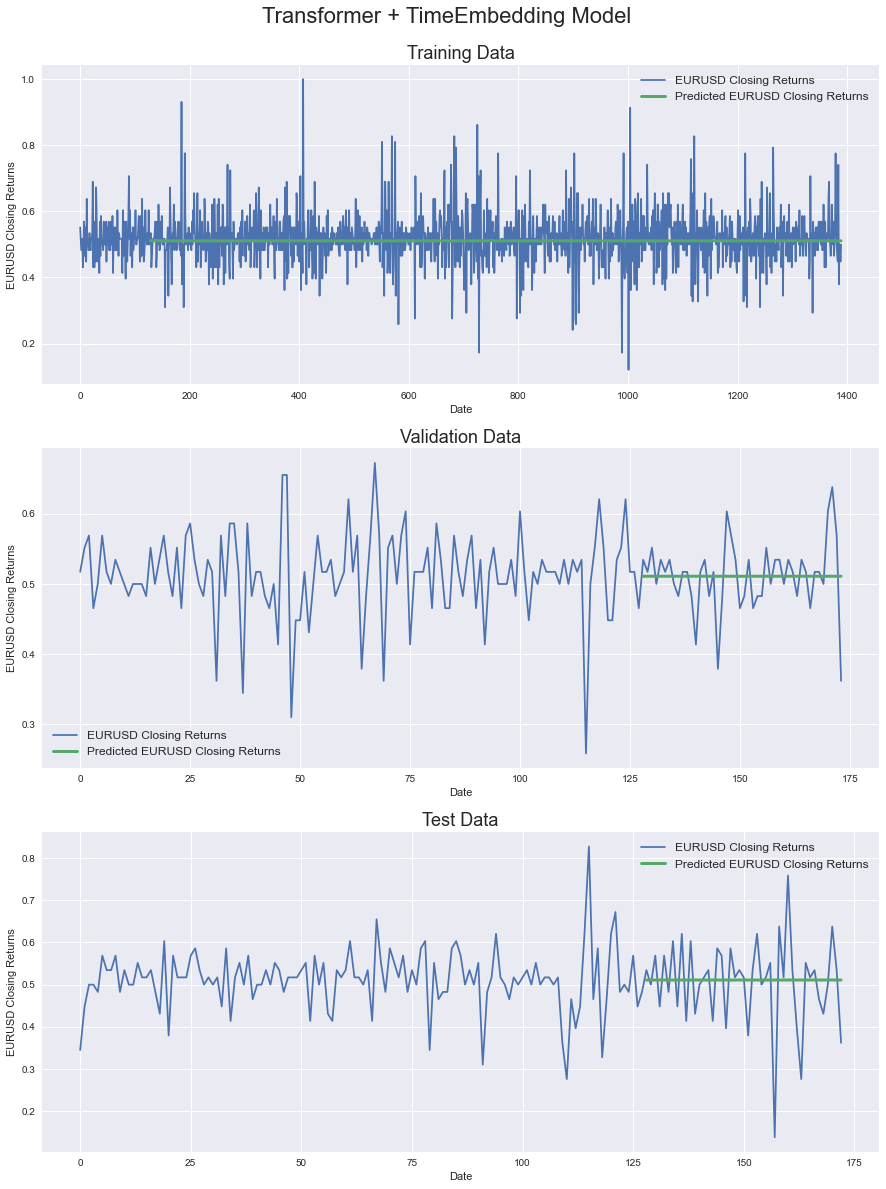

In [28]:
model = tf.keras.models.load_model('content/Transformer+TimeEmbedding.hdf5',
                                   custom_objects={'Time2Vector': Time2Vector, 
                                                   'SingleAttention': SingleAttention,
                                                   'MultiAttention': MultiAttention,
                                                   'TransformerEncoder': TransformerEncoder})


###############################################################################
'''Calculate predictions and metrics'''

#Calculate predication for training, validation and test data
train_pred = model.predict(X_train)
val_pred = model.predict(X_val)
test_pred = model.predict(X_test)

#Print evaluation metrics for all datasets
train_eval = model.evaluate(X_train, y_train, verbose=0)
val_eval = model.evaluate(X_val, y_val, verbose=0)
test_eval = model.evaluate(X_test, y_test, verbose=0)
print(' ')
print('Evaluation metrics')
print('Training Data - Loss: {:.4f}, MAE: {:.4f}, MAPE: {:.4f}'.format(train_eval[0], train_eval[1], train_eval[2]))
print('Validation Data - Loss: {:.4f}, MAE: {:.4f}, MAPE: {:.4f}'.format(val_eval[0], val_eval[1], val_eval[2]))
print('Test Data - Loss: {:.4f}, MAE: {:.4f}, MAPE: {:.4f}'.format(test_eval[0], test_eval[1], test_eval[2]))

###############################################################################
'''Display results'''

fig = plt.figure(figsize=(15,20))
st = fig.suptitle("Transformer + TimeEmbedding Model", fontsize=22)
st.set_y(0.92)

#Plot training data results
ax11 = fig.add_subplot(311)
ax11.plot(train_data[:, 3], label='EURUSD Closing Returns')
ax11.plot(np.arange(seq_len, train_pred.shape[0]+seq_len), train_pred, linewidth=3, label='Predicted EURUSD Closing Returns')
ax11.set_title("Training Data", fontsize=18)
ax11.set_xlabel('Date')
ax11.set_ylabel('EURUSD Closing Returns')
ax11.legend(loc="best", fontsize=12)

#Plot validation data results
ax21 = fig.add_subplot(312)
ax21.plot(val_data[:, 3], label='EURUSD Closing Returns')
ax21.plot(np.arange(seq_len, val_pred.shape[0]+seq_len), val_pred, linewidth=3, label='Predicted EURUSD Closing Returns')
ax21.set_title("Validation Data", fontsize=18)
ax21.set_xlabel('Date')
ax21.set_ylabel('EURUSD Closing Returns')
ax21.legend(loc="best", fontsize=12)

#Plot test data results
ax31 = fig.add_subplot(313)
ax31.plot(test_data[:, 3], label='EURUSD Closing Returns')
ax31.plot(np.arange(seq_len, test_pred.shape[0]+seq_len), test_pred, linewidth=3, label='Predicted EURUSD Closing Returns')
ax31.set_title("Test Data", fontsize=18)
ax31.set_xlabel('Date')
ax31.set_ylabel('EURUSD Closing Returns')
ax31.legend(loc="best", fontsize=12)

## Model metrics

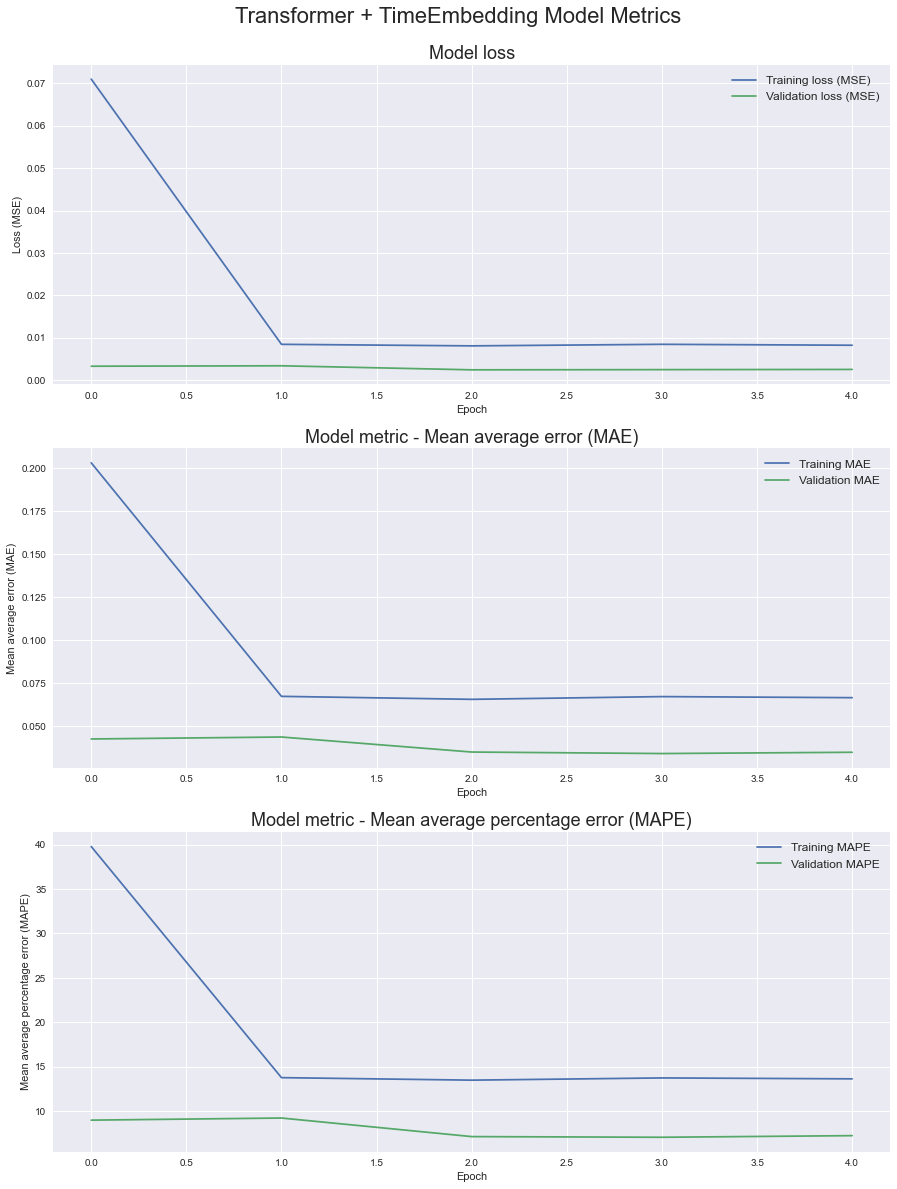

In [29]:
'''Display model metrics'''

fig = plt.figure(figsize=(15,20))
st = fig.suptitle("Transformer + TimeEmbedding Model Metrics", fontsize=22)
st.set_y(0.92)

#Plot model loss
ax1 = fig.add_subplot(311)
ax1.plot(history.history['loss'], label='Training loss (MSE)')
ax1.plot(history.history['val_loss'], label='Validation loss (MSE)')
ax1.set_title("Model loss", fontsize=18)
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss (MSE)')
ax1.legend(loc="best", fontsize=12)

#Plot MAE
ax2 = fig.add_subplot(312)
ax2.plot(history.history['mae'], label='Training MAE')
ax2.plot(history.history['val_mae'], label='Validation MAE')
ax2.set_title("Model metric - Mean average error (MAE)", fontsize=18)
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Mean average error (MAE)')
ax2.legend(loc="best", fontsize=12)

#Plot MAPE
ax3 = fig.add_subplot(313)
ax3.plot(history.history['mape'], label='Training MAPE')
ax3.plot(history.history['val_mape'], label='Validation MAPE')
ax3.set_title("Model metric - Mean average percentage error (MAPE)", fontsize=18)
ax3.set_xlabel('Epoch')
ax3.set_ylabel('Mean average percentage error (MAPE)')
ax3.legend(loc="best", fontsize=12)

## Model architecture overview

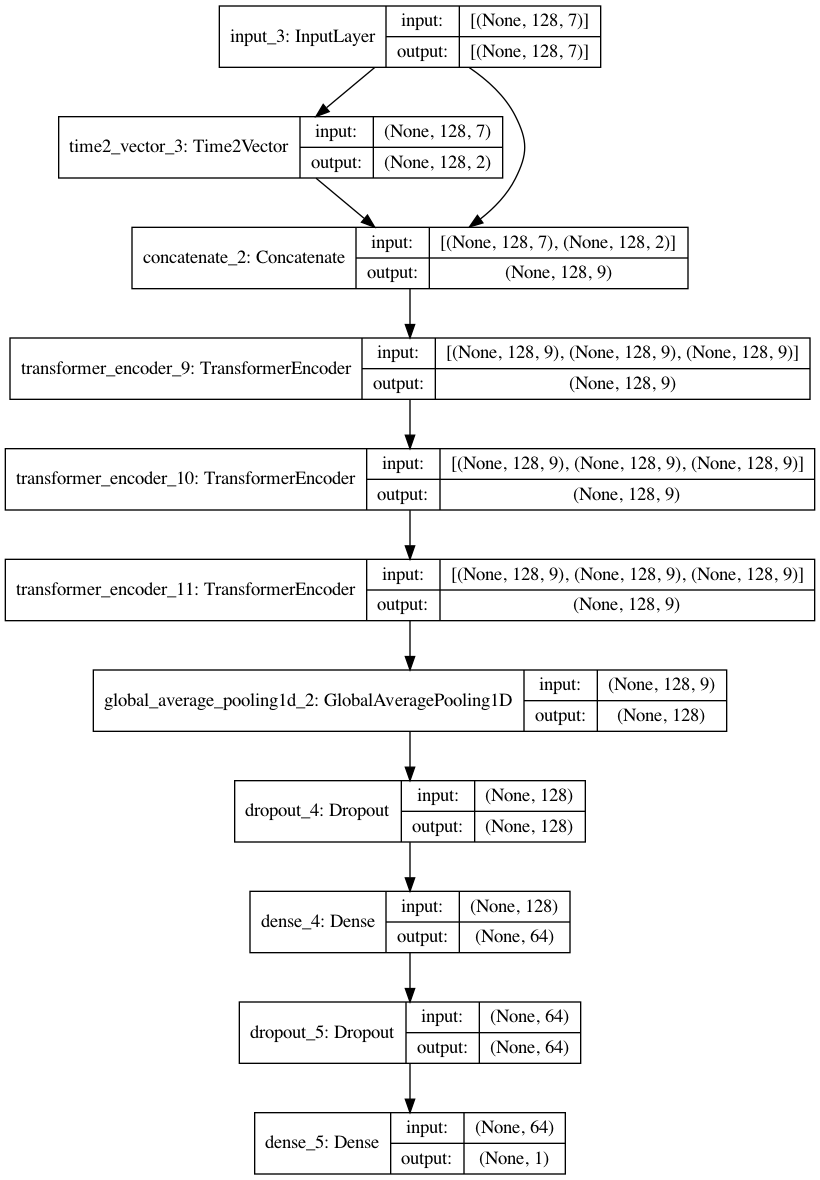

In [30]:
tf.keras.utils.plot_model(
    model,
    to_file="EURUSD_Transformer+TimeEmbedding.png",
    show_shapes=True,
    show_layer_names=True,
    expand_nested=True,
    dpi=96,)

# Moving Average

## Moving Average - Load EURUSD data again, to apply rolling window

In [34]:
IBM_path = '/Users/tizianfischer/Desktop/EURUSD4.csv'

df = pd.read_csv(IBM_path, delimiter=';', usecols=['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'Value', 'Number Ticks'])

# Replace 0 to avoid dividing by 0 later on
df['Volume'].replace(to_replace=0, method='ffill', inplace=True) 
df.sort_values('Date', inplace=True)

# Apply moving average with a window of 10 days to all columns
df[['Open', 'High', 'Low', 'Close', 'Volume', 'Value', 'Number Ticks']] = df[['Open', 'High', 'Low', 'Close', 'Volume', 'Value', 'Number Ticks']].rolling(10).mean() 

# Drop all rows with NaN values
df.dropna(how='any', axis=0, inplace=True) 
df.head()

,Date,Open,High,Low,Close,Volume,Value,Number Ticks
9,15.12.20 00:01,1.214499,1.214533,1.214458,1.214499,140809995.8,171012520.0,22.5
10,15.12.20 00:01,1.214490,1.214527,1.214451,1.214492,142344995.1,172875974.4,22.4
11,15.12.20 00:01,1.214486,1.214512,1.214447,1.214482,144674994.5,175704852.8,22.5
17,15.12.20 00:02,1.214479,1.214503,1.214439,1.214468,141984994.3,172436950.4,21.8
16,15.12.20 00:02,1.214473,1.214492,1.214434,1.214463,139589994.2,169527248.0,21.1


## Moving Average - Plot daily EURUSD closing prices and volume

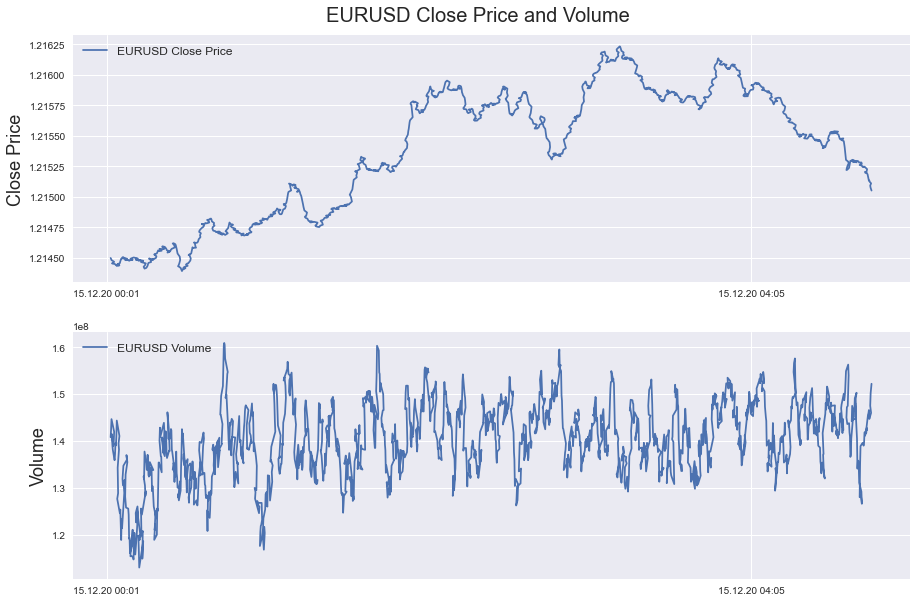

In [35]:
fig = plt.figure(figsize=(15,10))
st = fig.suptitle("EURUSD Close Price and Volume", fontsize=20)
st.set_y(0.92)

ax1 = fig.add_subplot(211)
ax1.plot(df['Close'], label='EURUSD Close Price')
ax1.set_xticks(range(0, df.shape[0], 1464))
ax1.set_xticklabels(df['Date'].loc[::1464])
ax1.set_ylabel('Close Price', fontsize=18)
ax1.legend(loc="upper left", fontsize=12)

ax2 = fig.add_subplot(212)
ax2.plot(df['Volume'], label='EURUSD Volume')
ax2.set_xticks(range(0, df.shape[0], 1464))
ax2.set_xticklabels(df['Date'].loc[::1464])
ax2.set_ylabel('Volume', fontsize=18)
ax2.legend(loc="upper left", fontsize=12)

## Moving Average - Calculate normalized percentage change for all columns

In [36]:
'''Calculate percentage change'''

df['Open'] = df['Open'].pct_change() # Create arithmetic returns column
df['High'] = df['High'].pct_change() # Create arithmetic returns column
df['Low'] = df['Low'].pct_change() # Create arithmetic returns column
df['Close'] = df['Close'].pct_change() # Create arithmetic returns column
df['Volume'] = df['Volume'].pct_change()
df['Value'] = df['Value'].pct_change()
df['Number Ticks'] = df['Number Ticks'].pct_change()

df.dropna(how='any', axis=0, inplace=True) # Drop all rows with NaN values

###############################################################################
'''Normalize price columns'''

min_return = min(df[['Open', 'High', 'Low', 'Close']].min(axis=0))
max_return = max(df[['Open', 'High', 'Low', 'Close']].max(axis=0))

# Min-max normalize price columns (0-1 range)
df['Open'] = (df['Open'] - min_return) / (max_return - min_return)
df['High'] = (df['High'] - min_return) / (max_return - min_return)
df['Low'] = (df['Low'] - min_return) / (max_return - min_return)
df['Close'] = (df['Close'] - min_return) / (max_return - min_return)

###############################################################################
'''Normalize volume column'''

min_volume = df['Volume'].min(axis=0)
max_volume = df['Volume'].max(axis=0)

# Min-max normalize volume columns (0-1 range)
df['Volume'] = (df['Volume'] - min_volume) / (max_volume - min_volume)

###############################################################################
'''Normalize value column'''

min_value = df['Value'].min(axis=0)
max_value = df['Value'].max(axis=0)

# Min-max normalize value columns (0-1 range)
df['Value'] = (df['Value'] - min_value) / (max_value - min_value)

###############################################################################
'''Normalize number ticks column'''

min_numberticks = df['Number Ticks'].min(axis=0)
max_numberticks = df['Number Ticks'].max(axis=0)

# Min-max normalize number ticks columns (0-1 range)
df['Number Ticks'] = (df['Number Ticks'] - min_numberticks) / (max_numberticks - min_numberticks)

###############################################################################
'''Create training, validation and test split'''

times = sorted(df.index.values)
last_10pct = sorted(df.index.values)[-int(0.1*len(times))] # Last 10% of series
last_20pct = sorted(df.index.values)[-int(0.2*len(times))] # Last 20% of series

df_train = df[(df.index < last_20pct)]  # Training data are 80% of total data
df_val = df[(df.index >= last_20pct) & (df.index < last_10pct)]
df_test = df[(df.index >= last_10pct)]

# Remove date column
df_train.drop(columns=['Date'], inplace=True)
df_val.drop(columns=['Date'], inplace=True)
df_test.drop(columns=['Date'], inplace=True)

# Convert pandas columns into arrays
train_data = df_train.values
val_data = df_val.values
test_data = df_test.values
print('Training data shape: {}'.format(train_data.shape))
print('Validation data shape: {}'.format(val_data.shape))
print('Test data shape: {}'.format(test_data.shape))

df_train.head()

Training data shape: (1383, 7)
Validation data shape: (173, 7)
Test data shape: (172, 7)


,Open,High,Low,Close,Volume,Value,Number Ticks
10,0.445732,0.481911,0.469847,0.469850,0.562679,0.562639,0.471270
11,0.506026,0.373384,0.506024,0.433673,0.609523,0.609482,0.544979
17,0.469849,0.445733,0.457787,0.385436,0.309978,0.309917,0.250634
16,0.481908,0.421615,0.493965,0.493966,0.324761,0.324695,0.242369
15,0.481907,0.493967,0.530143,0.506025,0.426009,0.425981,0.390405


## Moving Average - Plot daily changes of close price and volume

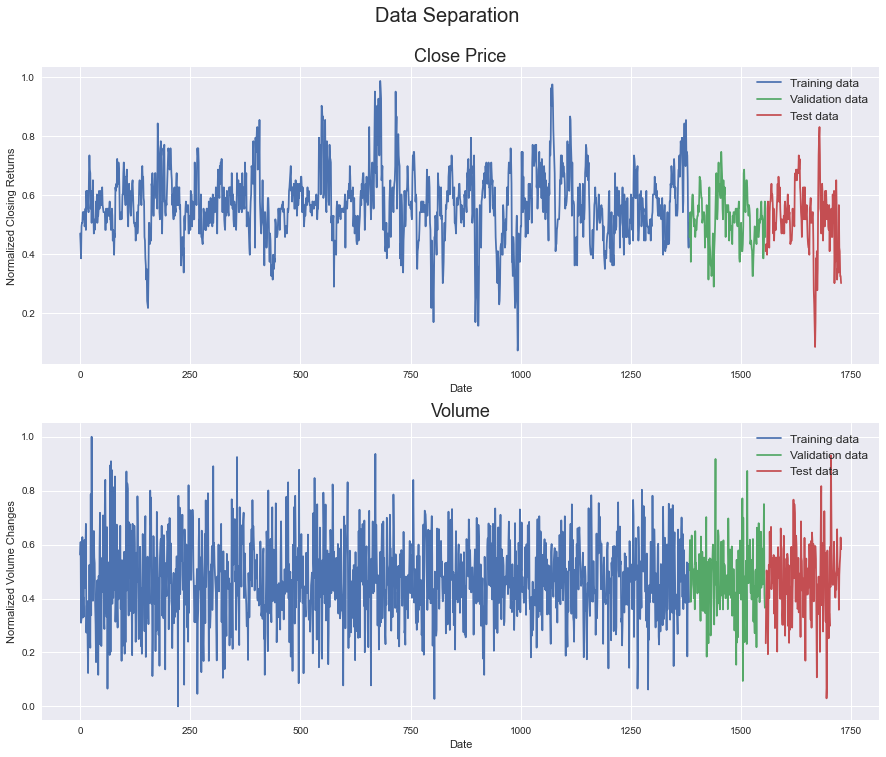

In [37]:
fig = plt.figure(figsize=(15,12))
st = fig.suptitle("Data Separation", fontsize=20)
st.set_y(0.95)

###############################################################################

ax1 = fig.add_subplot(211)
ax1.plot(np.arange(train_data.shape[0]), df_train['Close'], label='Training data')

ax1.plot(np.arange(train_data.shape[0], 
                   train_data.shape[0]+val_data.shape[0]), df_val['Close'], label='Validation data')

ax1.plot(np.arange(train_data.shape[0]+val_data.shape[0], 
                   train_data.shape[0]+val_data.shape[0]+test_data.shape[0]), df_test['Close'], label='Test data')
ax1.set_xlabel('Date')
ax1.set_ylabel('Normalized Closing Returns')
ax1.set_title("Close Price", fontsize=18)
ax1.legend(loc="best", fontsize=12)

###############################################################################

ax2 = fig.add_subplot(212)
ax2.plot(np.arange(train_data.shape[0]), df_train['Volume'], label='Training data')

ax2.plot(np.arange(train_data.shape[0], 
                   train_data.shape[0]+val_data.shape[0]), df_val['Volume'], label='Validation data')

ax2.plot(np.arange(train_data.shape[0]+val_data.shape[0], 
                   train_data.shape[0]+val_data.shape[0]+test_data.shape[0]), df_test['Volume'], label='Test data')
ax2.set_xlabel('Date')
ax2.set_ylabel('Normalized Volume Changes')
ax2.set_title("Volume", fontsize=18)
ax2.legend(loc="best", fontsize=12)

## Moving Average - Create chunks of training, validation, and test data

In [38]:
# Training data
X_train, y_train = [], []
for i in range(seq_len, len(train_data)):
  X_train.append(train_data[i-seq_len:i]) # Chunks of training data with a length of 128 df-rows
  y_train.append(train_data[:, 3][i]) #Value of 4th column (Close Price) of df-row 128+1
X_train, y_train = np.array(X_train), np.array(y_train)

###############################################################################

# Validation data
X_val, y_val = [], []
for i in range(seq_len, len(val_data)):
    X_val.append(val_data[i-seq_len:i])
    y_val.append(val_data[:, 3][i])
X_val, y_val = np.array(X_val), np.array(y_val)

###############################################################################

# Test data
X_test, y_test = [], []
for i in range(seq_len, len(test_data)):
    X_test.append(test_data[i-seq_len:i])
    y_test.append(test_data[:, 3][i])    
X_test, y_test = np.array(X_test), np.array(y_test)

print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)

(1255, 128, 7) (1255,)
(45, 128, 7) (45,)


## Moving Average - Model

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 128, 7)]     0                                            
__________________________________________________________________________________________________
time2_vector_4 (Time2Vector)    (None, 128, 2)       512         input_4[0][0]                    
__________________________________________________________________________________________________
concatenate_3 (Concatenate)     (None, 128, 9)       0           input_4[0][0]                    
                                                                 time2_vector_4[0][0]             
__________________________________________________________________________________________________
transformer_encoder_12 (Transfo (None, 128, 9)       124726      concatenate_3[0][0]        

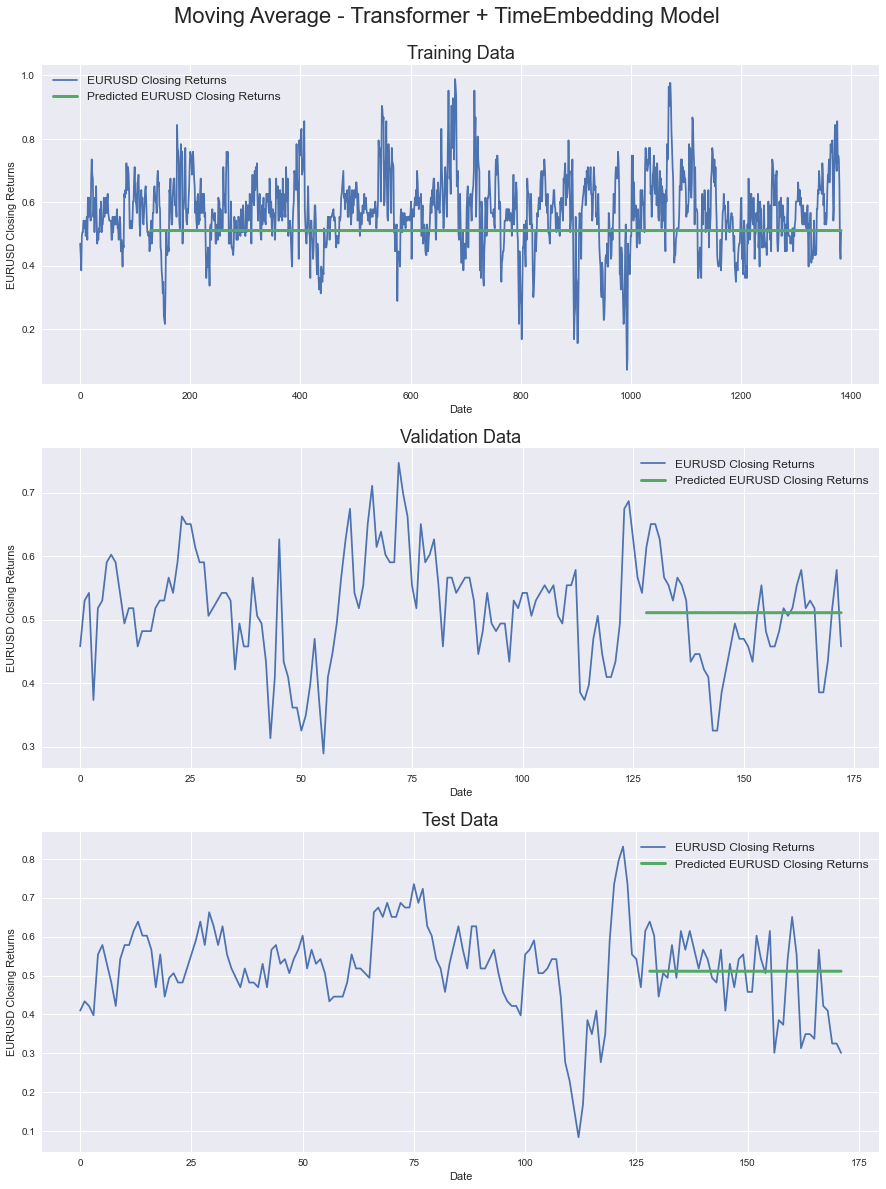

In [39]:
def create_model():
  '''Initialize time and transformer layers'''
  time_embedding = Time2Vector(seq_len)
  attn_layer1 = TransformerEncoder(d_k, d_v, n_heads, ff_dim)
  attn_layer2 = TransformerEncoder(d_k, d_v, n_heads, ff_dim)
  attn_layer3 = TransformerEncoder(d_k, d_v, n_heads, ff_dim)

  '''Construct model'''
  in_seq = Input(shape=(seq_len, 7))
  x = time_embedding(in_seq)
  x = Concatenate(axis=-1)([in_seq, x])
  x = attn_layer1((x, x, x))
  x = attn_layer2((x, x, x))
  x = attn_layer3((x, x, x))
  x = GlobalAveragePooling1D(data_format='channels_first')(x)
  x = Dropout(0.1)(x)
  x = Dense(64, activation='relu')(x)
  x = Dropout(0.1)(x)
  out = Dense(1, activation='linear')(x)

  model = Model(inputs=in_seq, outputs=out)
  model.compile(loss='mse', optimizer='adam', metrics=['mae', 'mape'])
  return model


model = create_model()
model.summary()

callback = tf.keras.callbacks.ModelCheckpoint('Transformer+TimeEmbedding.hdf5', 
                                              monitor='val_loss', 
                                              save_best_only=True, 
                                              verbose=1)

history = model.fit(X_train, y_train, 
                    batch_size=batch_size, 
                    epochs=5, 
                    callbacks=[callback],
                    validation_data=(X_val, y_val))  

model = tf.keras.models.load_model('content/Transformer+TimeEmbedding.hdf5',
                                   custom_objects={'Time2Vector': Time2Vector, 
                                                   'SingleAttention': SingleAttention,
                                                   'MultiAttention': MultiAttention,
                                                   'TransformerEncoder': TransformerEncoder})


###############################################################################
'''Calculate predictions and metrics'''

#Calculate predication for training, validation and test data
train_pred = model.predict(X_train)
val_pred = model.predict(X_val)
test_pred = model.predict(X_test)

#Print evaluation metrics for all datasets
train_eval = model.evaluate(X_train, y_train, verbose=0)
val_eval = model.evaluate(X_val, y_val, verbose=0)
test_eval = model.evaluate(X_test, y_test, verbose=0)
print(' ')
print('Evaluation metrics')
print('Training Data - Loss: {:.4f}, MAE: {:.4f}, MAPE: {:.4f}'.format(train_eval[0], train_eval[1], train_eval[2]))
print('Validation Data - Loss: {:.4f}, MAE: {:.4f}, MAPE: {:.4f}'.format(val_eval[0], val_eval[1], val_eval[2]))
print('Test Data - Loss: {:.4f}, MAE: {:.4f}, MAPE: {:.4f}'.format(test_eval[0], test_eval[1], test_eval[2]))

###############################################################################
'''Display results'''

fig = plt.figure(figsize=(15,20))
st = fig.suptitle("Moving Average - Transformer + TimeEmbedding Model", fontsize=22)
st.set_y(0.92)

#Plot training data results
ax11 = fig.add_subplot(311)
ax11.plot(train_data[:, 3], label='EURUSD Closing Returns')
ax11.plot(np.arange(seq_len, train_pred.shape[0]+seq_len), train_pred, linewidth=3, label='Predicted EURUSD Closing Returns')
ax11.set_title("Training Data", fontsize=18)
ax11.set_xlabel('Date')
ax11.set_ylabel('EURUSD Closing Returns')
ax11.legend(loc="best", fontsize=12)

#Plot validation data results
ax21 = fig.add_subplot(312)
ax21.plot(val_data[:, 3], label='EURUSD Closing Returns')
ax21.plot(np.arange(seq_len, val_pred.shape[0]+seq_len), val_pred, linewidth=3, label='Predicted EURUSD Closing Returns')
ax21.set_title("Validation Data", fontsize=18)
ax21.set_xlabel('Date')
ax21.set_ylabel('EURUSD Closing Returns')
ax21.legend(loc="best", fontsize=12)

#Plot test data results
ax31 = fig.add_subplot(313)
ax31.plot(test_data[:, 3], label='EURUSD Closing Returns')
ax31.plot(np.arange(seq_len, test_pred.shape[0]+seq_len), test_pred, linewidth=3, label='Predicted EURUSD Closing Returns')
ax31.set_title("Test Data", fontsize=18)
ax31.set_xlabel('Date')
ax31.set_ylabel('EURUSD Closing Returns')
ax31.legend(loc="best", fontsize=12)

## Moving Average - Model metrics

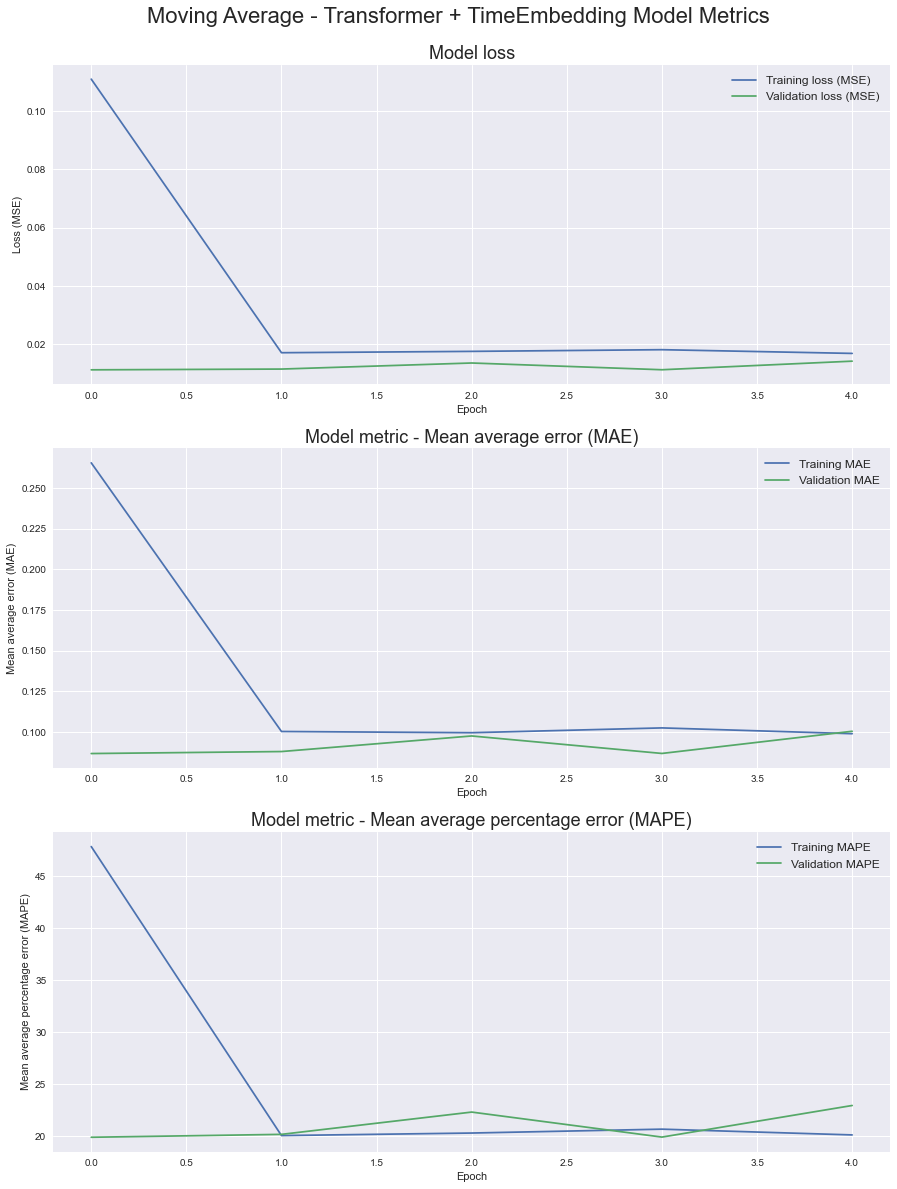

In [40]:
'''Display model metrics'''

fig = plt.figure(figsize=(15,20))
st = fig.suptitle("Moving Average - Transformer + TimeEmbedding Model Metrics", fontsize=22)
st.set_y(0.92)

#Plot model loss
ax1 = fig.add_subplot(311)
ax1.plot(history.history['loss'], label='Training loss (MSE)')
ax1.plot(history.history['val_loss'], label='Validation loss (MSE)')
ax1.set_title("Model loss", fontsize=18)
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss (MSE)')
ax1.legend(loc="best", fontsize=12)

#Plot MAE
ax2 = fig.add_subplot(312)
ax2.plot(history.history['mae'], label='Training MAE')
ax2.plot(history.history['val_mae'], label='Validation MAE')
ax2.set_title("Model metric - Mean average error (MAE)", fontsize=18)
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Mean average error (MAE)')
ax2.legend(loc="best", fontsize=12)

#Plot MAPE
ax3 = fig.add_subplot(313)
ax3.plot(history.history['mape'], label='Training MAPE')
ax3.plot(history.history['val_mape'], label='Validation MAPE')
ax3.set_title("Model metric - Mean average percentage error (MAPE)", fontsize=18)
ax3.set_xlabel('Epoch')
ax3.set_ylabel('Mean average percentage error (MAPE)')
ax3.legend(loc="best", fontsize=12)